In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import pandas as pd
import pickle
import sys
sys.path.append('/project2/andrewferguson/berlaga/activelearning')

from botorch.optim.optimize import optimize_acqf_discrete
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP 
from botorch.acquisition import ExpectedImprovement, LogExpectedImprovement, qExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.kernels import RBFKernel, ScaleKernel, MaternKernel
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
from botorch.models.transforms.outcome import Standardize
from botorch.acquisition.penalized import PenalizedAcquisitionFunction, L2Penalty, L1Penalty, GaussianPenalty

In [24]:
# scores = np.zeros((20, 20))
letters = 'CSTAGPDEQNHRKMILVWYF'
letters_peptoid = 'CSTAGPDEQNHRKMILVWYFJOXZ1'
letters_interesting = 'DFGHKPQRSVWY'
tensors = []
folders = []
confidences = np.zeros((20, 20))
s = []
number_1 = 0
number_2 = 0
number_3 = 0
for i, a in enumerate(letters):
    for j, b in enumerate(letters):
        folder = f'1shg_P{a}{b}P'
        if os.path.isfile(os.path.join(folder, 'trunk_repr.pt')):
            new_t = torch.load(os.path.join(folder, 'trunk_repr.pt'), map_location=torch.device('cpu'))
            new_t = new_t.reshape(new_t.shape[0], -1)
            
            if os.path.isfile(os.path.join(folder, 'aggregate1.npy')):
                score = np.load(os.path.join(folder, 'aggregate1.npy'))[0]
                s.append(score)
                tensors.append(new_t)
                folders.append(folder)
                number_1 += 1

for i, a in enumerate(letters_peptoid):
    for j, b in enumerate(letters_peptoid):
        folder = f'1shg_P{a}{b}P_t'
        if os.path.isfile(os.path.join(folder, 'trunk_repr.pt')):
            new_t = torch.load(os.path.join(folder, 'trunk_repr.pt'), map_location=torch.device('cpu'))
            new_t = new_t.reshape(new_t.shape[0], -1)
            
            if os.path.isfile(os.path.join(folder, 'aggregate.npy')):
                score = np.load(os.path.join(folder, 'aggregate.npy'))[0]
                s.append(score)
                tensors.append(new_t)
                folders.append(folder)
                number_2 += 1

for i, a in enumerate(letters_interesting):
    for j, b in enumerate(letters_interesting):
        for k, c in enumerate(letters_interesting):
            folder = f'1shg_{a}{b}{c}'
            if os.path.isfile(os.path.join(folder, 'trunk_repr.pt')):
                new_t = torch.load(os.path.join(folder, 'trunk_repr.pt'), map_location=torch.device('cpu'))
                new_t = new_t.reshape(new_t.shape[0], -1)
                
                if os.path.isfile(os.path.join(folder, 'aggregate.npy')):
                    score = np.load(os.path.join(folder, 'aggregate.npy'))[0]
                    s.append(score)
                    tensors.append(new_t)
                    folders.append(folder)
                    number_3 += 1

len(s), len(tensors), number_1, number_2, number_3

(2169, 2169, 400, 616, 1153)

In [25]:
stacked = torch.stack(tensors).reshape(len(tensors), -1)  # Shape: (num_tensors, num_rows, num_cols)
# stacked = torch.load('stacked_tensor.pt')
print(stacked.shape[1])
# Compare along the first dimension (across all tensors) to see if the rows are identical
comparison = torch.all(stacked == stacked[0], dim=0)
good_idxs = torch.where(torch.logical_not(comparison))[0]
print(good_idxs.shape)
stacked = stacked[:, good_idxs]
from sklearn.decomposition import PCA
pca = PCA()
stacked -= torch.mean(stacked, dim=0)
stacked /= torch.std(stacked, dim=0)
torch.save(stacked, 'stacked_tensor.pt')
# torch.save(torch.Tensor([s]), 'scores.pt')
transformed = pca.fit_transform(stacked)
new_idxs = []
# for idx in range(stacked.shape[1]):
#     if len(np.unique(stacked[:, idx])) > 10:
#         new_idxs.append(idx)
# print(len(new_idxs))
# stacked = stacked[:, new_idxs]
stacked, stacked.shape

98304
torch.Size([38783])


(tensor([[-0.6084, -0.2181, -0.0509,  ...,  0.0215, -0.0215,  0.0215],
         [-0.6739, -0.1688,  0.5591,  ...,  0.0215, -0.0215,  0.0215],
         [-0.6302, -0.5388, -0.1586,  ...,  0.0215, -0.0215,  0.0215],
         ...,
         [-1.2200,  0.1519,  1.7254,  ...,  0.0215, -0.0215,  0.0215],
         [-0.1061, -0.2181,  2.3174,  ...,  0.0215, -0.0215,  0.0215],
         [ 1.5320,  0.3493,  2.3892,  ...,  0.0215, -0.0215,  0.0215]]),
 torch.Size([2169, 38783]))

In [26]:
stacked = torch.load('stacked_tensor.pt')
# s = torch.load('scores.pt')
import torch
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, layer_1)
        self.fc2 = nn.Linear(layer_1, layer_2)
        self.fc3 = nn.Linear(layer_2, latent_dim * 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        mu = x[:, :latent_dim]
        logvar = x[:, latent_dim:]
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, layer_2)
        self.fc2 = nn.Linear(layer_2, layer_1)
        self.fc3 = nn.Linear(layer_1, output_dim)

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = torch.sigmoid(self.fc3(z))
        return z

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar 


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

# Example usage
input_dim = stacked.shape[1]
layer_1 = 256
layer_2 = 64
latent_dim = 3


In [46]:
from tqdm import tqdm
from torch import optim
from torch.utils.data import DataLoader, random_split
ratio = 1
train_size, test_size = int(ratio * len(stacked)), len(stacked) - int(ratio * len(stacked))


torch.manual_seed(42069)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
vae = VAE(input_dim, latent_dim).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.0005)
mean = stacked.mean(dim=0)
std = stacked.std(dim=0)
print(mean.shape, std.shape)
# Normalize data
stacked = (stacked - mean) / std
concat = torch.cat((stacked.to(device), torch.Tensor([s]).to(device).T), dim=1)
train_dataset, test_dataset = random_split(concat, [train_size, test_size])
# d = stacked - mean
# Assuming you have a dataset 'dataset'
tested_idxs = torch.zeros(len(s), 1)
dgs = torch.zeros(len(s), 1)
dg_vals = pd.read_csv('../funnel_md/dg.csv')

for folder in os.listdir('../funnel_md'):
    if folder[5:] in list(dg_vals["Sequence"]) and folder in folders:
        new_idx = folders.index(folder)
        tested_idxs[new_idx] = 1
        dgs[new_idx] = dg_vals[dg_vals["Sequence"] == folder[5:]]["dG"].to_numpy()[0]

# print(torch.Tensor([s]).shape, train_dataset.shape)
# dataloader = torch.utils.data.DataLoader(torch.cat((d, tested_idxs, dgs), dim=1), batch_size=64, shuffle=True)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# print(d[0])
# print(d[1])
num_epochs = 50

for epoch in range(num_epochs):
    overall_loss = 0
    overall_kl = 0
    overall_dg = 0
    overall_recon = 0
    for data in dataloader:
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae(data[:, :-1])
        # Calculate reconstruction loss (e.g., mean squared error)
        reconstruction_loss = F.mse_loss(reconstruction, data[:, :-1])
        # cur_tested_idxs = data[:, -2].to(torch.int32)
        # print(cur_tested_idxs)
        cur_scores = data[:, -1]
        latent_dists = torch.norm(mu[:, None] - mu[None, :], dim=2)
        # print(latent_dists.grad)
        mld = torch.mean(latent_dists)
        sld = torch.std(latent_dists)
        latent_dists = (latent_dists - mld) / sld
        
        score_dists = torch.abs(cur_scores[:, None] - cur_scores[None, :])
        # print(dg_dists[cur_tested_idxs, cur_tested_idxs])
        mldg = torch.mean(score_dists)
        sldg = torch.std(score_dists)
        score_dists = (score_dists - mldg) / sldg
        dg_loss = torch.mean((latent_dists[:, :] - score_dists[:, :]) ** 2)
        # Calculate KL divergence
        kl_divergence = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1, dim=1).mean()
        # Total loss
        loss =  reconstruction_loss +   kl_divergence + dg_loss
        overall_recon += reconstruction_loss
        overall_kl += kl_divergence
        overall_dg += dg_loss
        overall_loss += loss
        loss.backward()
        # print(dg_loss.grad)
        
        optimizer.step()
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {overall_loss.item()}, Reconstruction: {reconstruction_loss}, KL: {kl_divergence}, dG: {dg_loss}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {overall_loss.item()}, Reconstruction: {overall_recon}, KL: {overall_kl}, dG: {overall_dg}")

cuda:0
torch.Size([38783]) torch.Size([38783])
Epoch 1/50, Loss: 371872169984.0, Reconstruction: 39.36030960083008, KL: 371872169984.0, dG: 56.46721649169922
Epoch 2/50, Loss: 153473264.0, Reconstruction: 34.464263916015625, KL: 153473248.0, dG: 53.47273635864258
Epoch 3/50, Loss: 126.51717376708984, Reconstruction: 34.029361724853516, KL: 47.453704833984375, dG: 45.034122467041016
Epoch 4/50, Loss: 94.6993408203125, Reconstruction: 34.01124954223633, KL: 19.486970901489258, dG: 41.20111846923828
Epoch 5/50, Loss: 88.26447296142578, Reconstruction: 33.98667907714844, KL: 15.389991760253906, dG: 38.88780975341797
Epoch 6/50, Loss: 87.21080780029297, Reconstruction: 33.9964485168457, KL: 15.233077049255371, dG: 37.98126983642578
Epoch 7/50, Loss: 87.36090850830078, Reconstruction: 33.98690414428711, KL: 16.188119888305664, dG: 37.185890197753906
Epoch 8/50, Loss: 80.70219421386719, Reconstruction: 33.98394775390625, KL: 12.676177024841309, dG: 34.04206848144531
Epoch 9/50, Loss: 79.21990

In [47]:
from scipy.spatial.distance import pdist

def init_GPR(X_train, y_train, yvar_train=None):
    """
    This function initializes a Gaussian Process Regression (GPR) model using GPyTorch.
    
    Args:
      X_train (torch.Tensor): Training features.
      y_train (torch.Tensor): Training target values (melting temperatures in this case).
      yvar_train (torch.Tensor, optional): Training noise levels (defaults to None).
    
    Returns:
      SingleTaskGP: A trained SingleTaskGP model from GPyTorch.
    """
    # Define the kernel function: Radial Basis Function (RBF) with scaling
    min_dist = np.min(pdist(X_train))
    max_dist = np.max(pdist(X_train))
    mean_dist = np.mean(pdist(X_train))
    kernel = RBFKernel(ard_num_dims=2, lengthscale_constraint=Interval(min_dist, max_dist / 3))
    # kernel = ScaleKernel(base_kernel=RBFKernel(ard_num_dims=2, lengthscale_constraint=Interval(min_dist, max_dist), outcome_transform=Standardize(m=1)))
    # Define the model: SingleTaskGP with specified properties

    mean = torch.mean(y_train)
    std = torch.std(y_train)

    y_scaled = (y_train - mean) / std
    
    
    
    if yvar_train is None:
        model = SingleTaskGP(train_X=X_train, train_Y=y_train,
                         covar_module=kernel, outcome_transform=Standardize(m=1))
    else:
        model = SingleTaskGP(train_X=X_train, train_Y=y_train, train_Yvar=yvar_train,
                         covar_module=kernel, outcome_transform=Standardize(m=1))
    
    
    # Define the marginal log likelihood for training
    mll = ExactMarginalLogLikelihood(model.likelihood, model) 
    
    # Define the optimizer (Adam)
    optimizer = torch.optim.Adam([
    {'params': model.parameters()},], lr=0.01)
    
    mll = mll.to(X_train)

    fit_gpytorch_model(mll, max_retries=100)
    model.eval()  
    # Print the learned lengthscales of the RBF kernel
    # print("Fit parameters: ", model.covar_module.lengthscale ) #covar_module_multi.module.base_kernel.lengthscale)
    # Return the trained GPR model
    return model

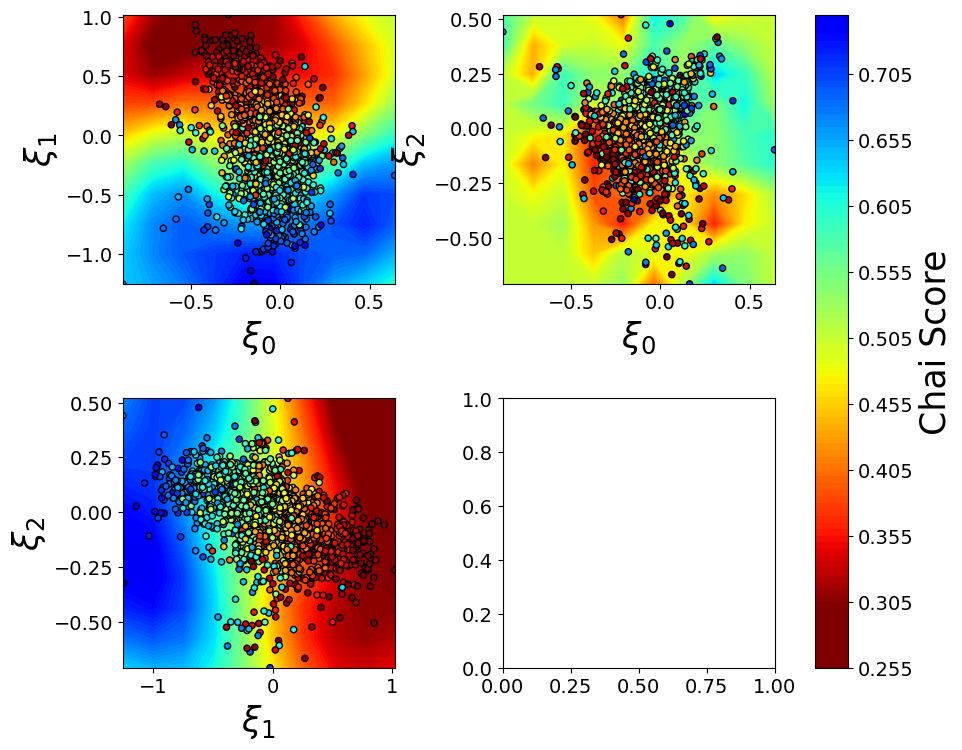

In [48]:
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams['font.size'] = 25
matplotlib.rcParams['figure.figsize'] = (15, 12)
embedding = vae(stacked.to(device))[1].cpu().detach().numpy()
from scipy.stats import kde
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, RBF
torch.manual_seed(42069)
# embedding = transformed
# print(embedding.shape)
# embedding = transformed
n_grid = 10
fig, ax = plt.subplots(latent_dim - 1,latent_dim - 1, figsize=[5 * (latent_dim - 1), 4 * (latent_dim - 1)])
for i in range(latent_dim - 1):
    for j in range(i+1, latent_dim):
        # kernel = RBF(1, length_scale_bounds=[0.005, (np.max(embedding[:, i]) - np.min(embedding[:, i])) ** 2])
        positions = torch.Tensor(embedding[:, [i, j]]).to(torch.float64)
        # print(positions.shape)
        gpr = init_GPR(positions, torch.Tensor(s).reshape(-1, 1).to(torch.float64))
        xi, yi = np.meshgrid(np.linspace(np.min(embedding[:, i]), np.max(embedding[:, i]), n_grid ), np.linspace(np.min(embedding[:, j]), np.max(embedding[:, j]), n_grid), indexing='ij')
        f = np.reshape(gpr.posterior(torch.Tensor([xi.flatten(), yi.flatten()]).T).loc.detach().numpy(), (n_grid, n_grid))
        if latent_dim == 2:
            c = plt.contourf(f.T, levels=100, cmap='jet_r', extent=[np.min(embedding[:, i]), np.max(embedding[:, i]), np.min(embedding[:, j]), np.max(embedding[:, j])] , vmin=0.3, vmax=0.8)
            plt.scatter(embedding[:, i], embedding[:, j], s=20, c=test_dataset[:, :-1], cmap='jet_r', vmin=0.3, vmax=0.8, edgecolors='black')
            plt.xlabel(f"$ \\xi_{i}$")
            plt.ylabel(f"$ \\xi_{j}$")
        else:
            c = ax[i, j-i-1].contourf(f.T, levels=100, cmap='jet_r', extent=[np.min(embedding[:, i]), np.max(embedding[:, i]), np.min(embedding[:, j]), np.max(embedding[:, j])] , vmin=0.3, vmax=0.8)
            ax[i, j-i-1].scatter(embedding[:, i], embedding[:, j], s=20, c=s, cmap='jet_r', vmin=0.3, vmax=0.8, edgecolors='black')
            ax[i, j-i-1].set_xlabel(f"$ \\xi_{i}$")
            ax[i, j-i-1].set_ylabel(f"$ \\xi_{j}$")

plt.tight_layout(pad=1)
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('Chai Score')
plt.show()

(25,)


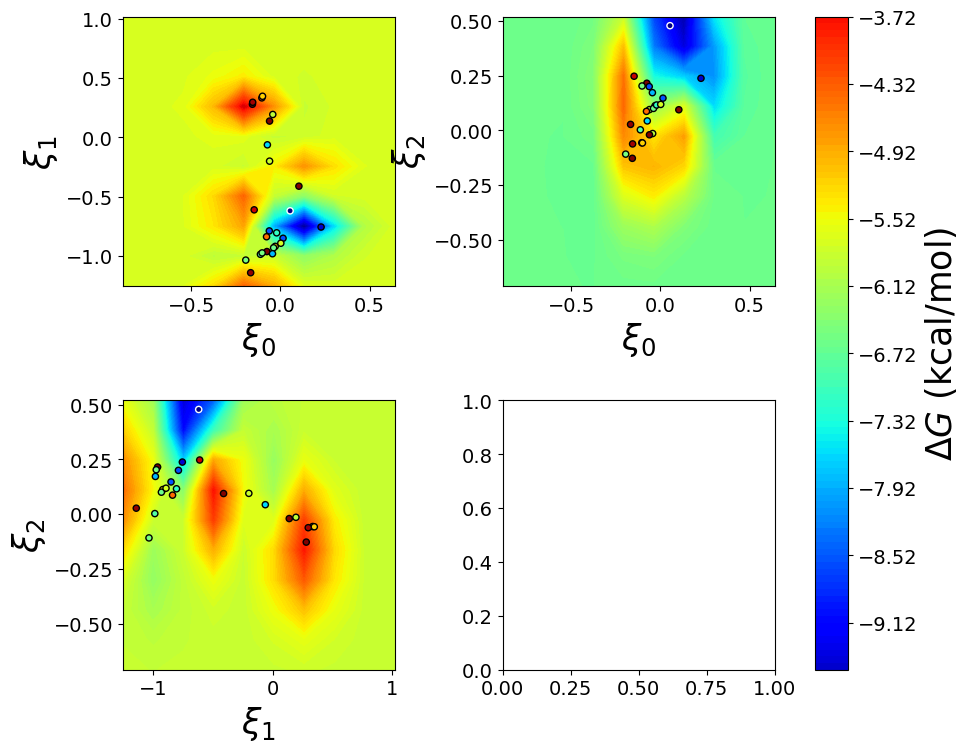

In [49]:
import pandas as pd
def map_color(x):
    return 'black' if x > -10 else 'white'
tidx = np.where(tested_idxs.detach().numpy())[0]
good_dgs = dgs[tidx].detach().numpy()
print(tidx.shape)
n_grid = 10
fig, ax = plt.subplots(latent_dim - 1,latent_dim - 1, figsize=[5 * (latent_dim - 1), 4 * (latent_dim - 1)])
for i in range(latent_dim - 1):
    for j in range(i+1, latent_dim):
        # kernel = RBF(1, length_scale_bounds=[0.005, (np.max(embedding[:, i]) - np.min(embedding[:, i])) ** 2])
        positions = torch.Tensor(embedding[tidx][:, [i, j]]).to(torch.float64)
        gpr = init_GPR(positions, torch.Tensor([good_dgs]).reshape(-1, 1).to(torch.float64))
        xi, yi = np.meshgrid(np.linspace(np.min(embedding[:, i]), np.max(embedding[:, i]), n_grid ), np.linspace(np.min(embedding[:, j]), np.max(embedding[:, j]), n_grid), indexing='ij')
        f = np.reshape(gpr.posterior(torch.Tensor([xi.flatten(), yi.flatten()]).T).loc.detach().numpy(), (n_grid, n_grid))
        if latent_dim == 2:
            c = plt.contourf(f.T, levels=100, cmap='jet', extent=[np.min(embedding[:, i]), np.max(embedding[:, i]), np.min(embedding[:, j]), np.max(embedding[:, j])] , vmin=-14, vmax=-3)
            plt.scatter(embedding[tidx, i], embedding[tidx, j], s=20, c=good_dgs, cmap='jet', vmin=10, vmax=-3, edgecolors=[map_color(g) for g in good_dgs])
            plt.xlabel(f"$ \\xi_{i}$")
            plt.ylabel(f"$ \\xi_{j}$")
        else:
            c = ax[i, j-i-1].contourf(f.T, levels=100, cmap='jet', extent=[np.min(embedding[:, i]), np.max(embedding[:, i]), np.min(embedding[:, j]), np.max(embedding[:, j])] , vmin=-10, vmax=-3)
            ax[i, j-i-1].scatter(embedding[tidx, i], embedding[tidx, j], s=20, c=good_dgs, cmap='jet', vmin=-10, vmax=-3, edgecolors=[map_color(g) for g in good_dgs])
            ax[i, j-i-1].set_xlabel(f"$ \\xi_{i}$")
            ax[i, j-i-1].set_ylabel(f"$ \\xi_{j}$")

plt.tight_layout(pad=1)
cbar = fig.colorbar(c, ax=ax)
cbar.ax.set_ylabel('$\Delta G$ (kcal/mol)')
plt.show()

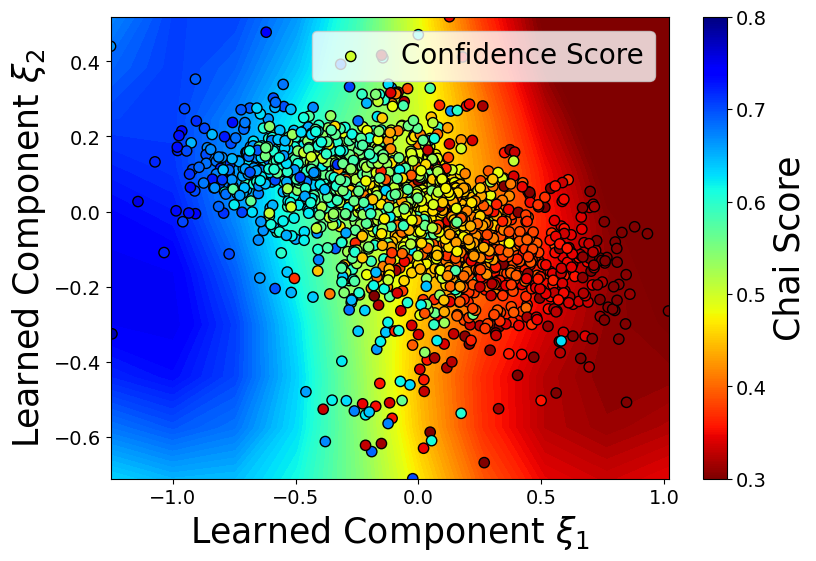

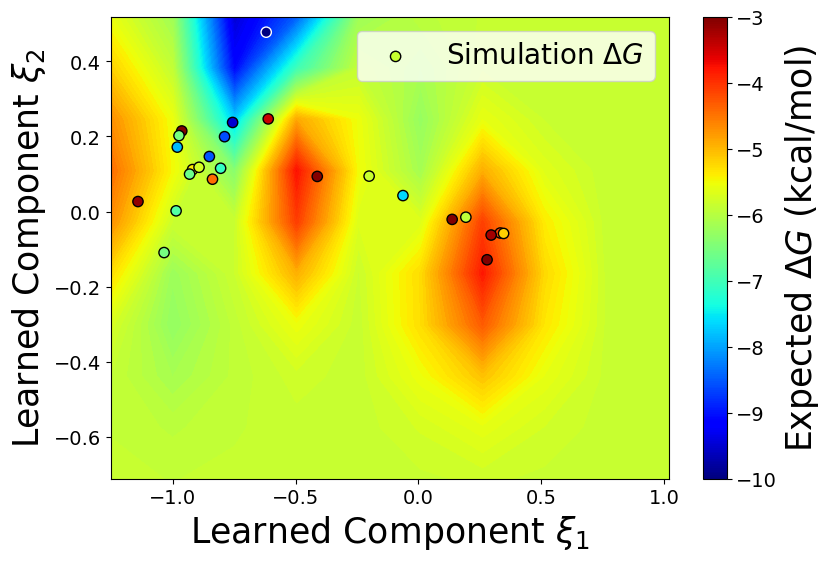

In [50]:
def map_color(x):
    return 'black' if x > -10 else 'white'
positions = torch.Tensor(embedding[:][:, [1, 2]]).to(torch.float64)
gpr = init_GPR(positions, torch.Tensor([s]).reshape(-1, 1).to(torch.float64))
xi, yi = np.meshgrid(np.linspace(np.min(embedding[:, 1]), np.max(embedding[:, 1]), n_grid ), np.linspace(np.min(embedding[:, 2]), np.max(embedding[:, 2]), n_grid), indexing='ij')
f = np.reshape(gpr.posterior(torch.Tensor([xi.flatten(), yi.flatten()]).T).loc.detach().numpy(), (n_grid, n_grid))
plt.figure(figsize=[9, 6])
c = plt.contourf(f.T, levels=100, cmap='jet_r', extent=[np.min(embedding[:, 1]), np.max(embedding[:, 1]), np.min(embedding[:, 2]), np.max(embedding[:, 2])] , vmin=0.3, vmax=0.8)
plt.scatter(embedding[:, 1], embedding[:, 2], s=55, c=s, cmap='jet_r', vmin=0.3, vmax=0.8, edgecolors='black', label='Confidence Score')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Chai Score')
plt.legend(fontsize=20)
plt.xlabel(f"Learned Component $ \\xi_{1}$")
plt.ylabel(f"Learned Component $ \\xi_{2}$")
plt.show()

positions = torch.Tensor(embedding[tidx][:, [1, 2]]).to(torch.float64)
gpr = init_GPR(positions, torch.Tensor([good_dgs]).reshape(-1, 1).to(torch.float64))
xi, yi = np.meshgrid(np.linspace(np.min(embedding[:, 1]), np.max(embedding[:, 1]), n_grid ), np.linspace(np.min(embedding[:, 2]), np.max(embedding[:, 2]), n_grid), indexing='ij')
f = np.reshape(gpr.posterior(torch.Tensor([xi.flatten(), yi.flatten()]).T).loc.detach().numpy(), (n_grid, n_grid))
plt.figure(figsize=[9, 6])
c = plt.contourf(f.T, levels=100, cmap='jet', extent=[np.min(embedding[:, 1]), np.max(embedding[:, 1]), np.min(embedding[:, 2]), np.max(embedding[:, 2])] , vmin=-10, vmax=-3)
plt.scatter(embedding[tidx, 1], embedding[tidx, 2], s=55, c=good_dgs, cmap='jet', vmin=-10, vmax=-3, edgecolors=[map_color(g) for g in good_dgs], label='Simulation $\Delta G$')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Expected $\Delta G$ (kcal/mol)')
plt.legend(fontsize=20)
plt.xlabel(f"Learned Component $ \\xi_{1}$")
plt.ylabel(f"Learned Component $ \\xi_{2}$")
plt.show()

In [40]:
gpr.covar_module.lengthscale

tensor([[0.6347, 0.1078]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [76]:
positions.shape, np.unique(positions, axis=0).shape

(torch.Size([400, 2]), (15, 2))

In [51]:
from sklearn.decomposition import PCA
pca = PCA()
stacked -= mean
transformed = pca.fit_transform(stacked)


In [62]:
fs = np.array(folders)
fs[embedding[:,0] < -0.7][np.argsort(embedding[:,0][embedding[:,0] < -0.7])]

array(['1shg_PVPP', '1shg_PLWP', '1shg_PLHP', '1shg_PMPP', '1shg_PDPP',
       '1shg_PTPP', '1shg_PFPP', '1shg_PMWP', '1shg_PLPP', '1shg_PKKP',
       '1shg_RYD', '1shg_PAWP', '1shg_PMHP', '1shg_PNPP', '1shg_PKQP',
       '1shg_PAHP', '1shg_PKWP', '1shg_PFHP', '1shg_PNPP_t', '1shg_PPPP',
       '1shg_PKHP', '1shg_PIPP', '1shg_PMKP', '1shg_PKRP', '1shg_PTHP',
       '1shg_PQQP', '1shg_PRWP', '1shg_PRKP', '1shg_PSPP', '1shg_PLKP',
       '1shg_PMQP', '1shg_PKPP', '1shg_PQKP', '1shg_PFWP', '1shg_PKNP',
       '1shg_PRHP', '1shg_PYPP', '1shg_PNOP_t', '1shg_PAPP',
       '1shg_PIQP_t', '1shg_PGWP', '1shg_PRQP', '1shg_PLRP', '1shg_PHPP',
       '1shg_PQOP_t', '1shg_HPF', '1shg_PIKP', '1shg_PIQP', '1shg_PRTP',
       '1shg_PVRP_t', '1shg_YPH', '1shg_PKEP', '1shg_PKMP', '1shg_PWPP',
       '1shg_PQPP', '1shg_RHW', '1shg_PEPP', '1shg_PKFP', '1shg_PKYP',
       '1shg_PTWP', '1shg_PRNP', '1shg_PQWP', '1shg_PLQP', '1shg_PMRP',
       '1shg_PSWP', '1shg_PTKP', '1shg_PMYP', '1shg_PPYP_t', '1shg_PTRP

In [198]:
fs[transformed[:, 1] > 100]

array(['1shg_PCCP_t', '1shg_PCAP_t', '1shg_PCGP_t', '1shg_PCDP_t',
       '1shg_PCEP_t', '1shg_PCNP_t', '1shg_PCHP_t', '1shg_PCKP_t',
       '1shg_PCMP_t', '1shg_PCIP_t', '1shg_PCLP_t', '1shg_PCFP_t',
       '1shg_PCJP_t', '1shg_PCOP_t', '1shg_PACP_t', '1shg_PATP_t',
       '1shg_PAHP_t', '1shg_PAMP_t', '1shg_PAVP_t', '1shg_PAWP_t',
       '1shg_PA1P_t'], dtype='<U11')

In [178]:
fs[transformed[:, 2] > 100]

array(['1shg_PDRP', '1shg_PERP', '1shg_PACP_t', '1shg_PAQP_t',
       '1shg_PANP_t', '1shg_PAHP_t', '1shg_PAMP_t', '1shg_DDD',
       '1shg_DDR'], dtype='<U11')

In [58]:
tested_idxs

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [100]:
torch.cat((d, tested_idxs, dgs), dim=1).shape

torch.Size([1051, 38785])

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [72]:
test_dataset.dataset

tensor([[-0.7885, -0.2010,  0.1197,  ..., -0.0239,  0.0239,  0.4994],
        [-0.8589, -0.1550,  0.7479,  ..., -0.0239,  0.0239,  0.4884],
        [-0.8120, -0.5001,  0.0089,  ..., -0.0239,  0.0239,  0.5872],
        ...,
        [-1.5156,  0.4662,  1.6348,  ..., -0.0239,  0.0239,  0.7067],
        [-0.6009, -1.2134,  1.2837,  ..., -0.0239,  0.0239,  0.7020],
        [ 1.5101,  0.3281,  2.6325,  ..., -0.0239,  0.0239,  0.7767]],
       device='cuda:0')